# Continuous Time Markov Chains I: Introduction

## Overview

To be added.  Focus is on time-homogeneous chains.  Finite state space.

The state space is $S = \{x_1, \ldots, x_n\}$, where each $x_i$ is a real number.

Informally, a continuous time $S$-valued Markov chain $(X_t)_{t \geq 0}$ is an $S$-valued stochastic process indexed by $t \in \mathbb R_+$ that has the Markov property.

Having the Markov property means that $(X_t)_{t < r}$ and $(X_t)_{t \geq r}$ are independent given $X_r$.

As we will see, the Markov property imposes a great deal of valuable structure.

We will use the following imports

In [46]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit


## Poisson Processes

We will use a well-known relationship between exponential and Poisson
random variables.

In what follows, $Y \sim E(\lambda)$ means that $Y$ is exponential with rate $\lambda$,
so 

$$
    \mathbb P\{Y > y\} = e^{-\lambda y}
    \quad \text{  for all } 
    y \geq 0
$$

Let $\lambda > 0$ be given and let $\{W_i\}$ be an IID sequence drawn from $E(\lambda)$.

Let

$$
    J_k := W_1 + \cdots W_k 
    \quad \text{with} \quad
    J_0 = 0
$$

For example, imagine a queue of infinite length, with customer 1 at the front,
customer 2 next, etc.

Let $W_i$ is the amount of time that customer $i$ waits in the
queue. 

Then $J_k$ is the time that the $k$-th customer is served, while

$$
    N_t := \sum_{k \geq 0} k \mathbb 1\{ J_k \leq t < J_{k+1} \}
$$

is the number of customers served by time $t$.

The next figure illustrate the definition of $N_t$ for a given jump sequence $\{J_k\}$.

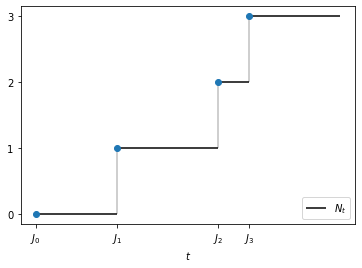

In [47]:
# Hide code
Ks = 0, 1, 2, 3
Js = 0, 0.8, 1.8, 2.1, 3
n = len(Ks)

fig, ax = plt.subplots()

ax.plot(Js[:-1], Ks, 'o')
ax.hlines(Ks, Js[:-1], Js[1:], label='$N_t$')
ax.vlines(Js[:-1], (0, Ks[0], Ks[1], Ks[2]), Ks, alpha=0.25)

ax.set(xticks=Js[:-1],
       xticklabels=[f'$J_{k}$' for k in range(n)],
       yticks=(0, 1, 2, 3),
       xlabel='$t$')

ax.legend(loc='lower right')
plt.show()

An alternative but equivalent definition is

$$
    N_t = \max \{k \geq 0 \,|\, J_k \leq t \}
$$

As a function of $t$, the process $N_t$ is called a **counting process**.

**Proposition**  For each $t > 0$, the random variable $N_t$ has the Poisson
distribution with parameter $t \lambda$, so that

$$ 
    \mathbb P\{N_t =k\} 
    = e^{-t \lambda} \frac{(t \lambda)^k }{k!}
    \qquad (k = 0, 1, \ldots)
$$

[For a proof, see Norris Thm. 2.4.3.]

An exercise at the end of the lecture asks you to test this (informally) via simulation.


## A Model of Inventory Dynamics

Let's now meet our first continuous time Markov chain on a finite state space.

Let $X_t$ be the inventory of a firm at time $t$,
taking values in the integers $0, 1, \ldots, b$.

If $X_t > 0$, then a customer arrives after $W$
units of time, where $W \sim E(\lambda)$ for some fixed $\lambda > 0$.

Each customer purchases $\min\{U, X_t\}$ units, where $U$ is an IID draw from
the geometric distribution

$$
    \mathbb P\{U = u\} = (1-\alpha)^{k-1} \alpha
    \qquad (k = 1, 2, \ldots, \; \alpha \in (0, 1))
$$

If $X_t = 0$, then no customers arrive and the firm places an order for $b$ units.

The order arrives after a delay of $D$ units of time, where $D \sim E(\lambda)$.

(We use the same $\lambda$ here just for convenience, to simplify the exposition.)

### Representation

The inventory process jumps to a new value either when a new customer arrives
$(X_t > 0)$ or when new stock arrives $(X_t = 0)$.

Between these arrival times it is constant.

Hence, to track $X_t$, it is enough to track the jump times and the new values
taken at the jumps.

In what follows, we denote the jump times by $\{J_k\}$ and the values at jumps
by $Y_k$.

Then 

$$
    X_t = \sum_{k \geq 0} Y_k \mathbb 1\{J_k \leq t < J_{k+1}\}
    \qquad (t \geq 0)
$$ (xfromy)



### Simulation

Let's simulate this process, starting at $X_0 = 0$.

As above,

* $\{J_k\}$ gives the time of the jumps in inventory.
* $Y_k$ gives the size of the inventory after the $k$-th jump.
* $(X_t)$ is defined from these objects via {eq}`xfromy`.

Here's a function that simulates one path.

In [48]:
def sim_path(seed=123, sim_length=30, λ=0.5, α=0.7, b=10):

    J = np.zeros(sim_length)
    Y = np.zeros(sim_length)
    k = 0
    np.random.seed(seed)

    for k in range(sim_length-1):
        W = np.random.exponential(scale=1/λ)  # W ~ E(λ)
        J[k+1] = J[k] + W
        if Y[k] == 0:
            Y[k+1] = b
        else:
            Y[k+1] = Y[k] - min(Y[k], np.random.geometric(α))
    return J, Y

Let's plot the process $\{X_t\}$ using the ``step`` method of ``ax``.

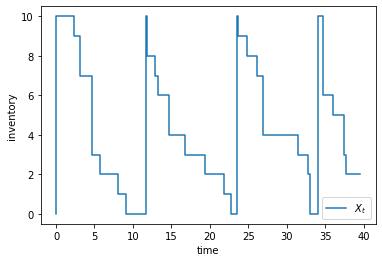

In [49]:
J, Y = sim_path()

fig, ax = plt.subplots()
ax.step(J, Y, label="$X_t$")

ax.set(xlabel="time", ylabel="inventory")

ax.legend()
plt.show()

As expected, inventory falls and then jumps back up to $b$.

We might now ask questions such as "What fraction of time does $X_t = 0$ hold
over a long time series?"

Before we dig deeper, however, let us turn to some definitions.

## Markov Processes

A continuous time stochastic process $(X_t)$ on $S$ is a family of $S$-valued
random variables $X_t$ defined on a common probability space.

The process $(X_t)$ is called a (time homogeneous) **Markov process** on $S$
if

$$
    \mathbb P\{X_t = x \,|\, (X_r)_{r \leq s} \}
    = \mathbb P\{X_t = x \,|\, X_s \}
$$

for all $x \in S$ and $s \leq t$.


## Exercises

Exercise 1
----------

Fix $\lambda > 0$ and draw $\{W_i\}$ independently from $E(\lambda)$.

Set $J_n := W_1 + \cdots W_n$ with $J_0 = 0$ and
    $N_t := \sum_{n \geq 0} n \mathbb 1\{ J_n \leq t < J_{n+1} \}$

Provide a visual test of the claim that $N_t$ is Poisson with parameter $t
\lambda$.

Do this by fixing $t = T$, generating many independent draws of $N_T$ and
comparing the empirical distribution of the sample with a Poisson
distribution with rate $T \lambda$.

Try first with $\lambda = 0.5$ and $T=10$.




## Solutions

Exercise 1
----------

Here is one solution.  

The figure shows that the fit is already good with a modest sample size.

Increasing the sample size will further improve the fit.

In [ ]:
λ = 0.5
T = 10

def poisson(k):
    "Poisson pmf with rate Tλ."
    r = T * λ
    return np.exp(-r) * (r**k) / sp.special.factorial(k)

@njit
def draw_Nt(max_iter=1e5):
    J = 0
    n = 0
    while n < max_iter:
        W = np.random.exponential(scale=1/λ)
        J += W
        if J > T:
            return n
        n += 1

@njit
def draw_Nt_sample(num_draws):
    draws = np.empty(num_draws)
    for i in range(num_draws):
        draws[i] = draw_Nt()
    return draws


sample_size = 10_000
sample = draw_Nt_sample(sample_size)
max_val = sample.max()
vals = np.arange(0, max_val+1)

fig, ax = plt.subplots()

ax.plot(vals, [poisson(v) for v in vals], 
    marker='o', label='poisson')
ax.plot(vals, [np.mean(sample==v) for v in vals], 
    marker='o', label='empirical')

ax.legend(fontsize=12)
plt.show()

